In [54]:
import math
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
from scipy.integrate import quad, trapz

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Расчет

Некоторые константы

In [55]:
Q_EC_76As=0.9233 #in MeV
Z_76As=33

g_a_g_v=1.297 #ratio of vector and axial coupling constants

BS05_OP_pep_ampl=1.42e8
pep_en=1.442 #MeV

S_n = 7.328 #энергия отрыва нейтрона

Функция для расчета порога реакции

In [56]:
def Q_k_func(E_k, Q_EC):
    #Считаем порог реакции, E_k - энергия возбужденного состояния в BGT
    #E_k in KeV
    return Q_EC+E_k/1000

Привиденная энергия вылетающего электрона: $\epsilon_e = \frac{E_{\nu}-Q_k}{m_e} + 1$

In [57]:
def e_e_func(E_nu, E_k, Q_EC):
    #Считаем привиденную энергию вылетающего электрона. Если энергия налетающего нейтрино E_nu
    #меньше порога, возвращаем 0 для обнуления итогового сечения
    #E_nu in MeV
    q=Q_k_func(E_k, Q_EC) #порог реакции
    if E_nu>q: return 1+(E_nu-q)/0.511
    else: return 0 

Привиденный импульс электрона: $\pi_e=\sqrt{\epsilon_e^2 -1}$

In [58]:
def Pi_e_func(e_e):
    #Привиденный импульс электрона, вычисляется через привиденную энергию; ** означает степень  
    if e_e>1: return math.sqrt(e_e**2 - 1)
    else: return 0

In [59]:
def integrate_func(a, b, x, y):
    return np.sum( np.interp(x=np.arange(a, b, 0.001), xp=x, fp=y ) * 0.001 )

### Fermi-function from Numerical Tables for Beta-Decay and Electron Capture

Ферми функия из оцифрованных немецких таблиц. Считываем данные

In [60]:
Fermi_func_new_data = pd.read_excel('../../fermi_func_tables/from_1968/13.xlsx')
Fermi_func_new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 14 columns):
P              49 non-null float64
F0L0           49 non-null float64
L0             48 non-null object
1z             48 non-null float64
13             48 non-null float64
ELECTRON
14    48 non-null float64
Z= 33
Izt      48 non-null float64
A= 77          48 non-null float64
A,             48 non-null float64
A2             48 non-null float64
VI2            48 non-null float64
912            48 non-null float64
12             48 non-null float64
Unnamed: 13    48 non-null float64
dtypes: float64(13), object(1)
memory usage: 5.4+ KB


Функция для расчета интерполированного значения. В таблице дана зависимость от импульса вылетающего электрона. Переводим ее в зав-ть от энергии электрона

In [61]:
e_e3 = np.sqrt( np.square( Fermi_func_new_data['P'].values ) + 1 ) #энергия вылетающего электрона
def num_tables_func(x):
    #x in units of mc^2
    return np.interp(x=x, xp=e_e3, fp=Fermi_func_new_data['F0L0'].values )

### B(GT) data

E_x до 5 МэВ!!!

In [62]:
BGT=pd.read_csv('../B(GT) peaks processing//clear_B(GT).csv') #таблица со значениями B(GT)
BGT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 5 columns):
Unnamed: 0        73 non-null int64
Ex                73 non-null float64
Jpi               73 non-null object
diff cross-sec    73 non-null float64
B(GT)             73 non-null float64
dtypes: float64(3), int64(1), object(1)
memory usage: 2.9+ KB


In [63]:
BGT['B(GT)'] = BGT['B(GT)']/10 #делим на 10 т.к. в таблице все значения домножены на 10

In [64]:
BGT = BGT[ BGT['Jpi'] == '1' ] #отбираем уравни с Jpi == 1

### BS05_OP flux

In [65]:
BS05_OP=pd.read_csv('../Vyborov_results/Fluxes/AllFluxes_BS05(OP).csv', sep=';')
BS05_OP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
energy    2000 non-null float64
pp        2000 non-null float64
hep       2000 non-null float64
N         2000 non-null float64
F         2000 non-null float64
O         2000 non-null float64
B         2000 non-null float64
dtypes: float64(7)
memory usage: 109.5 KB


создаем словарь, где ключ - название канала нейтрино (напр O или F), значение - двумерный массив, характеризующий интеполированные значения энергии и амплитуды для даннаго канала нейтрино 

In [66]:
all_fluxes_step = 0.01
Energy_all_fluxes = np.arange(0,20,0.01) #массив характеризующий шаги интегрирования

In [67]:
BS05_OP_dict = {}
for elem in list(BS05_OP.columns)[1:]:
    BS05_OP_dict.update({ elem : 
                        np.interp(x=Energy_all_fluxes, xp=BS05_OP['energy'], 
                                  fp=BS05_OP[elem] ) })

### Cross-section and total rate

### Расчет сечения с учетом только дискретных уровней 

Сечение по Иджири $\sigma_k={(1.597\times10^{-44}\ cm^2)}\epsilon_e \pi_e m_e^2 F(Z,E_e) [B(F)_k + (\frac{g_a}{g_v})^2 B(GT)_k] $ 

In [68]:
g_a_g_v_square = math.pow(g_a_g_v,2)
m_e_square = math.pow(0.511,2)

In [69]:
#расчет сечения до энергии возбуждения 5 МэВ
def sigma_k_less5(E_nu, E_k, BGT_k, Z, Q_EC):
    #E_k in kev
    #сечение k-го возб. состояния по Иджири
    e_e=e_e_func(E_nu, E_k, Q_EC) #энергия вылетающего электрона
    Pi_e=Pi_e_func(e_e) #его импульс
    F_col=num_tables_func(e_e) #значение ферм-функции при такой энергии
    return m_e_square*e_e*Pi_e*F_col*g_a_g_v_square*BGT_k

In [70]:
#функция расчета свертки сечения с потоком
def rate_calc(sigma):
    
    const = 1.597*math.pow(10,-44)

    sigma_total = np.array(sigma) * const
    
    rate_total = 0
    
    for elem in list(BS05_OP_dict.keys()):
        rate = sum(BS05_OP_dict[elem]*sigma_total*all_fluxes_step) * math.pow(10,36)
        print(elem, ' ', rate)
        rate_total+=rate
        
    sigma_pep = np.interp(pep_en, xp=Energy_all_fluxes, fp=sigma_total)
    rate_pep = BS05_OP_pep_ampl*sigma_pep*math.pow(10,36)
    print('pep', ' ', rate_pep)
    
    rate_total+=rate_pep
    print('rate_total',' ', rate_total)
        
#ВНИМАНИЕ: в расчетах pep не учитывается

    Считаем свертку потока с сечением. 
    BS05_OP_dict[elem] - массив со значениями амплитуды потока нейтрино для канала elem.
    sigma - массив со значениями суммарного сечения.
    all_fluxes_step - шаг интегрирования.
    math.pow(10,36) - для получения итогового значения в SNU. 

In [71]:
sigma_less5=[sum([sigma_k_less5(E_nu, E_k, BGT_k, Z_76As, Q_EC_76As) 
                  for (BGT_k, E_k) in zip(BGT['B(GT)'].values, BGT['Ex'].values)]) 
             for E_nu in Energy_all_fluxes]

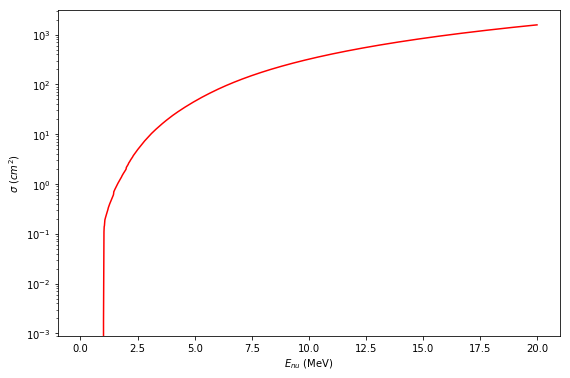

In [72]:
plt.figure(figsize=(9,6))
plt.plot(Energy_all_fluxes, sigma_less5, c='r')
plt.xlabel('$E_{nu}$ (MeV)')
plt.ylabel('$\sigma$ $(cm^2)$')
plt.yscale('log')
#plt.title('Сечение с учетом только дискретных состояний')

In [73]:
rate_calc(sigma_less5)

F   0.0210597366245
O   0.827549244942
N   0.101981181764
hep   0.0451063572066
pp   0.0
B   13.5423079221
pep   1.3685712782859079
rate_total   15.906575721


### Расчет сечения с учетом только GTR
GTR в виде гауссовского пика

In [74]:
def gauss(x, mu, sigma, k):
    y = k*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))
    return np.round(y, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов

Параметры взяты из декомпозиции

In [75]:
mu = 11.05338743
sigma = 2.04836474
k = 1.40655398

In [76]:
x_norm = np.arange(0, 28, 0.1)
y_norm = gauss(x_norm, mu, sigma, k)
trapz(y_norm, x_norm)

7.2219350000000002

B(GT) = 3(N-Z) = 36. Отнормируем гаусс

In [77]:
y_norm = y_norm/trapz(y_norm, x_norm)*36
trapz(y_norm, x_norm)

36.0

(5, 15)

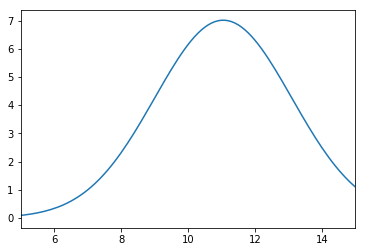

In [78]:
plt.plot(x_norm, y_norm)
plt.xlim(5,15)

In [79]:
#функция для отрезки резонансов выше энергии отрыва
def border_func(x_data, y_data, border):
    a=np.where(x_data<S_n)
    #print(len(a[0]), len(x_data)-len(a[0]), len(x_data), a[0])
    return np.hstack(( y_data[a], np.zeros(len(x_data)-len(a[0])) ))

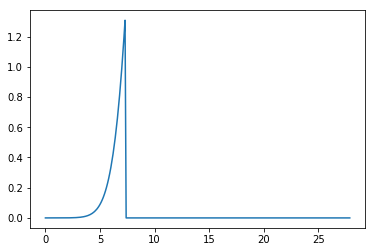

In [106]:
y_norm = border_func(x_norm, y_norm, S_n)
plt.plot(x_norm, y_norm)

Сечение для непрерывной части

$\sigma = {(1.597\times10^{-44}\ cm^2)} \int^{z-Q}_{0} {(\frac{g_a}{g_v})^2 \cdot \sqrt{(z-Q-x+0.511)^2-0.511^2} \cdot (z-Q-x+0.511) \cdot S_{GTR}(x) \cdot F(z-Q-x+0.511)} dx $ 


In [107]:
#введем новую переменную p = z - Q
def sigma_k_GTR(x, p, x_data, y_data):
    e_energy = p - x + 0.511
    return g_a_g_v_square*np.sqrt(e_energy**2-m_e_square)*e_energy*np.interp(x,xp=x_data,fp=y_data)*num_tables_func(e_energy/0.511) 


In [108]:
#разбиваем интервал интегрирования на субинтервалы
def intervals(a,b,n):
    c=np.linspace(a,b,num=n)
    return [[c[i], c[i+1]] for i in range(len(c)-1)]

In [109]:
#считаем сечение
def cross_sec(a,b, sigma_func, shape_x, shape_y, int_num=50):
    borders_list = intervals(a,b, int_num)
    #return sum([quad(sigma_func, i[0],i[1], args=(b,shape_x, shape_y))[0] for i in borders_list])
    return sum([sc.integrate.fixed_quad(sigma_func, i[0],i[1], args=(b,shape_x, shape_y))[0] for i in borders_list])
    #return sum([sc.integrate.romberg(sigma_func, i[0],i[1], args=(b,shape_x, shape_y)) for i in borders_list])

In [110]:
p_list = np.arange(0,20, 0.1) #p = z - Q

#sigma_more5_temp = [ quad(sigma_k_more5, 0, p, args=(p), limit=200)[0] for p in p_list]
#sigma_more5_temp = [ sc.integrate.fixed_quad(sigma_k_more5, 0, p, args=(p, x_norm, y_norm), n=20)[0] for p in p_list]
#sigma_more5_temp = [ sc.integrate.romberg(sigma_k_more5, 0, p, args=(p,)) for p in p_list]
#sigma_more5_temp = [sigma_more5_ab(p) for p in p_list]

sigma_GTR_temp = [cross_sec(0,p, sigma_k_GTR, x_norm, y_norm, 200) for p in p_list]

sigma_GTR = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_GTR_temp)
#sigma_more5_1 = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_more5_temp1)

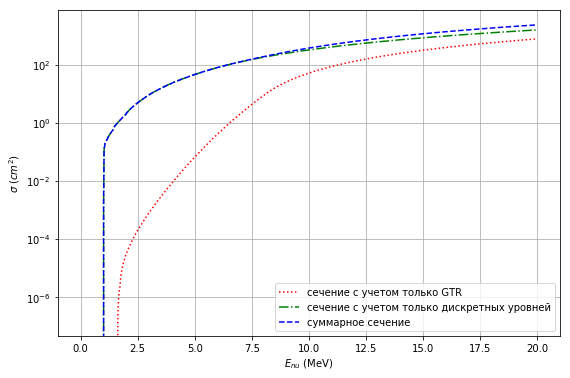

In [123]:
plt.figure(figsize=(9,6))
plt.plot(Energy_all_fluxes, sigma_GTR, ls=':', c='r', label='сечение с учетом только GTR')
plt.plot(Energy_all_fluxes, sigma_less5, ls='-.', c='g', label='сечение с учетом только дискретных уровней')
plt.plot(Energy_all_fluxes, sigma_less5+sigma_GTR, ls='--', c='b', label='суммарное сечение')
plt.xlabel('$E_{nu}$ (MeV)')
plt.ylabel('$\sigma$ $(cm^2)$')
plt.yscale('log')
plt.legend()
plt.grid()
#plt.title('Сечение с учетом только дискретных состояний')

plt.savefig('cross_sections.png', format='png', dpi=500)

In [112]:
rate_calc(sigma_less5+sigma_GTR)

F   0.0210597385022
O   0.827549308382
N   0.101981181764
hep   0.0570439768691
pp   0.0
B   15.2179685912
pep   1.3685712782859079
rate_total   17.594174075


### Расчет сечения с учетом только IAS
IAS в виде гауссовского пика, параметры взяты из декомпозиции

0.97211298999999807

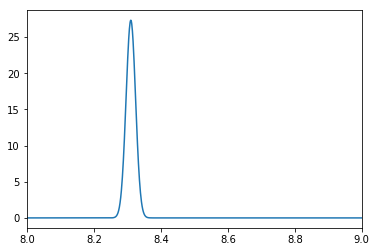

In [113]:
m_IAS = 8.31025152e+00
s_IAS = -1.41850172e-02
k_IAS = 2.73399015e+01

x_IAS = np.arange(0, 28, 0.001)
y_IAS = gauss(x_IAS, m_IAS, s_IAS, k_IAS)

plt.plot(x_IAS, y_IAS)
plt.xlim(8,9)
trapz(y_IAS, x_IAS)

IAS
(N-Z) = 12. Нормируем 

In [114]:
y_IAS = y_IAS/trapz(y_IAS, x_IAS)*12
trapz(y_IAS, x_IAS)

12.0

In [115]:
y_IAS = border_func(x_IAS, y_IAS, S_n)

Сечение для непрерывной части

$\sigma = {(1.597\times10^{-44}\ cm^2)} \int^{z-Q}_{0} {\sqrt{(z-Q-x+0.511)^2-0.511^2} \cdot (z-Q-x+0.511) \cdot S_{IAS}(x) \cdot F(z-Q-x+0.511)} dx $ 

In [116]:
def sigma_k_IAS(x, p, x_data, y_data):
    e_energy = p - x + 0.511
    return np.sqrt(e_energy**2-m_e_square)*e_energy*np.interp(x,xp=x_data,fp=y_data)*num_tables_func(e_energy/0.511) 


In [117]:

#sigma_IAS_temp = [ quad(sigma_k_IAS, 8.2, 8.4, args=(p, x_IAS, y_IAS), limit=200)[0] for p in p_list]
#sigma_IAS_temp = [ sc.integrate.fixed_quad(sigma_k_IAS, 8, p, args=(p, x_IAS, y_IAS), n=20)[0] for p in p_list]
#sigma_IAS_temp = [ sc.integrate.romberg(sigma_k_IAS, 8, p, args=(p, x_IAS, y_IAS)) for p in p_list]

sigma_IAS_temp = [cross_sec(0,p, sigma_k_IAS, x_IAS, y_IAS, 200) for p in p_list]

sigma_IAS = np.interp(Energy_all_fluxes, xp=p_list+Q_EC_76As, fp=sigma_IAS_temp)

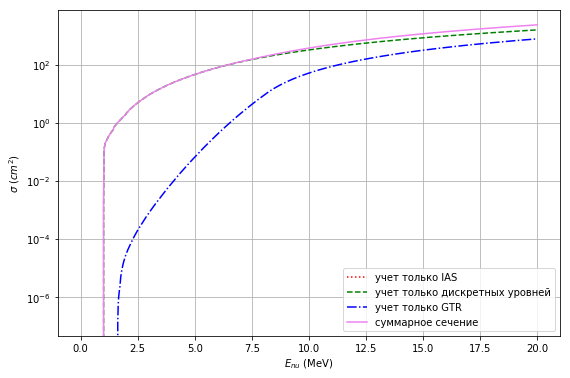

In [118]:
plt.figure(figsize=(9,6))
plt.plot(Energy_all_fluxes, sigma_IAS, c='r', ls=':', label='учет только IAS')
plt.plot(Energy_all_fluxes, sigma_less5, c='g', ls='--', label='учет только дискретных уровней')
plt.plot(Energy_all_fluxes, sigma_GTR, c='b', ls='-.', label='учет только GTR')
plt.plot(Energy_all_fluxes, sigma_less5+sigma_GTR+sigma_IAS, c='violet', label='суммарное сечение')
plt.xlabel('$E_{nu}$ (MeV)')
plt.ylabel('$\sigma$ $(cm^2)$')
plt.yscale('log')
plt.grid()
plt.legend()
#plt.title('Сечение с учетом только дискретных состояний')

#plt.savefig('cross_sections.png', format='png', dpi=500)

In [119]:
rate_calc(sigma_less5+sigma_GTR+sigma_IAS)

F   0.0210597385022
O   0.827549308382
N   0.101981181764
hep   0.0570439768691
pp   0.0
B   15.2179685912
pep   1.3685712782859079
rate_total   17.594174075


In [120]:
rate_calc(sigma_IAS)

F   0.0
O   0.0
N   0.0
hep   0.0
pp   0.0
B   0.0
pep   0.0
rate_total   0.0


In [121]:
rate_calc(sigma_GTR)

F   1.87766262189e-09
O   6.34405818376e-08
N   0.0
hep   0.0119376196625
pp   0.0
B   1.67566066906
pep   0.0
rate_total   1.68759835404


In [96]:
BS05_OP_dict.keys()

dict_keys(['F', 'O', 'N', 'hep', 'pp', 'B'])

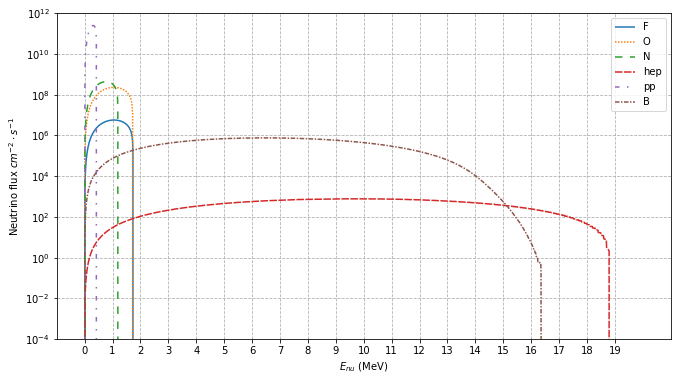

In [97]:
from collections import OrderedDict

linestyles = OrderedDict(
    [('solid',               (0, ())),
     ('densely dotted',      (0, (1, 1))),

     ('dashed',              (0, (5, 5))),
     ('densely dashed',      (0, (5, 1))),

     ('dashdotted',          (0, (3, 5, 1, 5))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))])

plt.figure(figsize=(11,6))
for (key, ls) in zip(BS05_OP_dict.keys(), linestyles.items()):
    plt.plot(Energy_all_fluxes, BS05_OP_dict[key], label=key, linestyle=ls[1])
plt.yscale('log')
plt.legend()
plt.xticks(np.arange(0,20,1))
plt.ylim(10**(-4),10**(12))
plt.xlabel('$E_{nu}$ (MeV)')
plt.ylabel('Neutrino flux $cm^{-2} \cdot s^{-1}$')
plt.grid(True,which="both",ls="--")

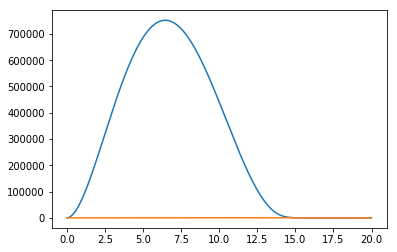

In [98]:
plt.plot(Energy_all_fluxes, BS05_OP_dict['B'])
plt.plot(Energy_all_fluxes, BS05_OP_dict['hep'])

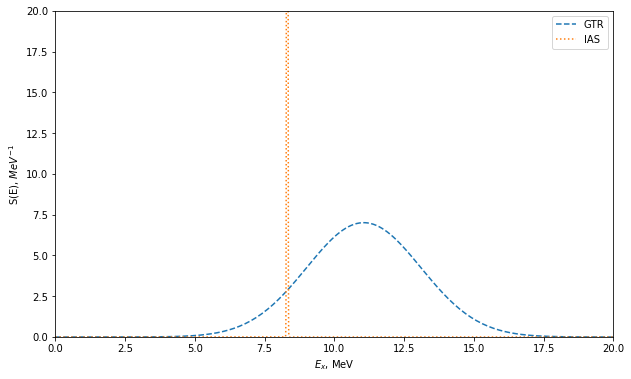

In [99]:
plt.figure(figsize=(10,6))
plt.plot(x_norm, y_norm, ls='--', label='GTR')
plt.plot(x_IAS, y_IAS, ls=':', label='IAS')
plt.ylim(0,20)
plt.xlim(0,20)
plt.legend()
plt.xlabel('$E_x$, MeV')
plt.ylabel('S(E), $MeV^{-1}$')

Немного технической работы для перепроверки на маткаде

In [100]:
GTR_df = pd.DataFrame({'x':x_norm, 'y':y_norm})
GTR_df.to_csv('gtr_influence/GTR.csv', sep=';')

In [101]:
sigma_GTR_df = pd.DataFrame({'Energy':Energy_all_fluxes, 'cross sec':sigma_GTR})
sigma_GTR_df.to_csv('gtr_influence/sigma_GTR.csv', sep=';')

In [102]:
sigma_IAS_df = pd.DataFrame({'Energy':Energy_all_fluxes, 'cross sec':sigma_IAS})
sigma_IAS_df.to_csv('gtr_influence/sigma_IAS.csv', sep=';')

In [103]:
Energy_all_fluxes_short = np.arange(0, 20, 0.5)
sigma_GTR_short_df = pd.DataFrame({'Energy':Energy_all_fluxes_short,
                                     'cross sec':np.interp(Energy_all_fluxes_short, xp=Energy_all_fluxes, fp=sigma_GTR)})

sigma_GTR_short_df.to_csv('gtr_influence/sigma_GTR_short.csv', sep=';')

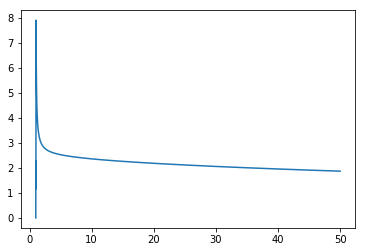

In [104]:
#fermi_func_df = pd.DataFrame({'Energy in m_e units':Energy_all_fluxes, 
#                              'f_value':num_tables_func(Energy_all_fluxes)})
#fermi_func_df.to_csv('gtr_influence/fermi_func.csv', sep=',')
fermi_func_df = pd.DataFrame({'Energy in m_e units':e_e3, 'f_value':Fermi_func_new_data['F0L0'].values})
fermi_func_df.to_csv('gtr_influence/fermi_func.csv', sep=';')

#a=num_tables_func(Energy_all_fluxes)
plt.plot(fermi_func_df['Energy in m_e units'], fermi_func_df['f_value'])

(0, 5)

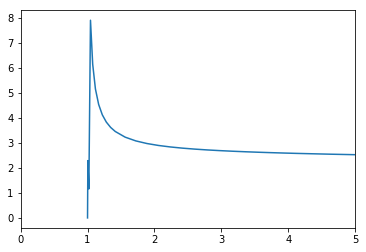

In [105]:
plt.plot(fermi_func_df['Energy in m_e units'], fermi_func_df['f_value'])
plt.xlim(0,5)